In [1]:
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import torch
from scipy import signal

In [2]:
# Load data
raw_data_path = list(Path("../stimuli/obvious_gaussian_clusters").iterdir())

data = []
 
for path in raw_data_path:
    data.append(np.load(path))
    
print("# of Stimuli: ", len(data))

stim = data[9]

print("Stimuli Shape: ", stim.shape)

# Normalize Data + convert to int
stim[:,0:2] = (stim[:,0:2]-np.min(stim[:,0:2])) * 10/(np.max(stim[:,0:2])-np.min(stim[:,0:2]))
stim = stim.astype(int)

# of Stimuli:  18
Stimuli Shape:  (20, 3)


<AxesSubplot:>

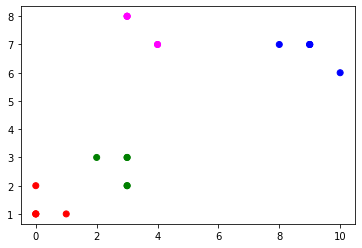

In [3]:
# Visualize Stimuli
colors = np.array(['red', 'blue', 'green', 'magenta', 'cyan', 'pink'])
def plot_stimuli(X):
    fig, ax = plt.subplots()
    c_idx = X[:, 2].astype(int)        
    c = colors[c_idx]
        
    ax.scatter(X[:, 0], X[:, 1], color=colors[X[:, 2].astype(int)])
    return ax

plot_stimuli(stim)

[[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


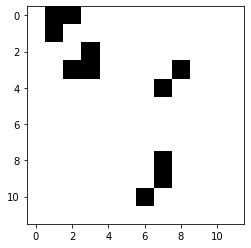

In [4]:
# Represent points as 2D image
im = np.zeros((12,12))
im[stim[:,0], stim[:,1]] = 1.0
print(im)

fig, ax2 = plt.subplots()
ax2.imshow(im, cmap='gray_r')

[[0.33333333 0.44444444 0.22222222 0.11111111]
 [0.22222222 0.44444444 0.33333333 0.22222222]
 [0.11111111 0.33333333 0.33333333 0.22222222]
 [0.11111111 0.22222222 0.22222222 0.11111111]]


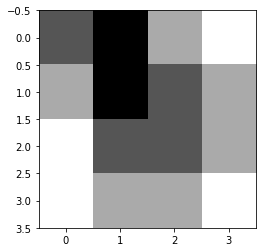

In [8]:
# Average Convolution

kernel = np.ones((3,3)).astype(float) / 9

def avg_conv_2d(im, filt):
    out = np.zeros((4,4)).astype(float)
    
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            out[i,j] = signal.convolve2d(im[i:i+3, j:j+3], filt, mode='valid')
    return out

    
out = avg_conv_2d(im, kernel)
print(out)

fig, ax3 = plt.subplots()
ax3.imshow(out, cmap='gray_r')